<a href="https://colab.research.google.com/github/brunomoraisnc/breast-cancer-nn-random-forest/blob/master/Breast_Cancer_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importações

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import normalize

### Leitura do arquivo

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1EMmkiIGX9cZiFRh0vRnhXxqUFFhV7tTO'
downloaded = drive.CreateFile({'id': file_id})

#print('Downloaded content "{}"'.format(downloaded.GetContentString()))

In [0]:
#@title
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO

TESTDATA = StringIO(downloaded.GetContentString())
df = pd.read_csv(TESTDATA, sep=",", header=None, index_col=None)

#df = pd.DataFrame(downloaded)

### Visão Geral

In [0]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [0]:
df.tail(5)

,0,1,2,3,4,5,6,7,8,9,10
694,776715,3,1,1,1,3,2,1,1,1,2
695,841769,2,1,1,1,2,1,1,1,1,2
696,888820,5,10,10,3,7,3,8,10,2,4
697,897471,4,8,6,4,3,4,10,6,1,4
698,897471,4,8,8,5,4,5,10,4,1,4


In [0]:
df.describe()

,0,1,2,3,4,5,7,8,9,10
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


#### Quantidade de ocorrências e tipo de dado

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
0     699 non-null int64
1     699 non-null int64
2     699 non-null int64
3     699 non-null int64
4     699 non-null int64
5     699 non-null int64
6     699 non-null object
7     699 non-null int64
8     699 non-null int64
9     699 non-null int64
10    699 non-null int64
dtypes: int64(10), object(1)
memory usage: 60.1+ KB


### Limpeza

In [0]:
# Linha 6 com ? para deletar
print(len(df[df[6] == '?']))

df = df.drop(df[df[6] == '?'].index)

16


In [0]:
df[df[6] == '?']

,0,1,2,3,4,5,6,7,8,9,10


#### Balanço pós-limpeza

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 683 entries, 0 to 698
Data columns (total 11 columns):
0     683 non-null int64
1     683 non-null int64
2     683 non-null int64
3     683 non-null int64
4     683 non-null int64
5     683 non-null int64
6     683 non-null object
7     683 non-null int64
8     683 non-null int64
9     683 non-null int64
10    683 non-null int64
dtypes: int64(10), object(1)
memory usage: 64.0+ KB


### Gráfico de calor para avaliar correlação

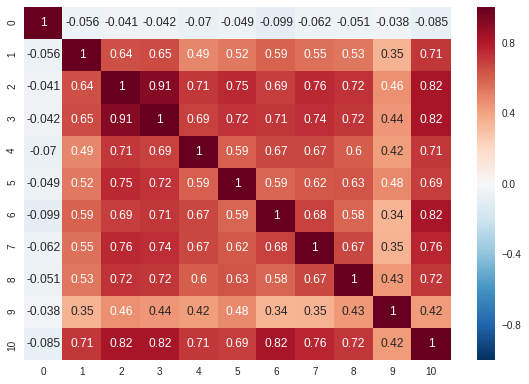

In [0]:
df[6] = pd.to_numeric(df[6])
corr = df.corr()

plt.clf()
sns.heatmap(corr, annot=True)
plt.tight_layout()
plt.show()

### Segmentação

#### Separação Vetor de características e Classe

In [0]:
X = df.iloc[:,1:10]
y = df.iloc[:,10]

In [0]:
#df.drop(0,axis=1, inplace=True)

##### Checagem

In [0]:
X.head()

,1,2,3,4,5,6,7,8,9
0,5,1,1,1,2,1,3,1,1
1,5,4,4,5,7,10,3,2,1
2,3,1,1,1,2,2,3,1,1
3,6,8,8,1,3,4,3,7,1
4,4,1,1,3,2,1,3,1,1


In [0]:
y.head()

0    2
1    2
2    2
3    2
4    2
Name: 10, dtype: int64

In [0]:
#df.drop_duplicates

### Normalização

In [0]:
from sklearn.preprocessing import Normalizer

transformer = Normalizer().fit(X)
X = pd.DataFrame(transformer.transform(X))

In [0]:
X.head()

,0,1,2,3,4,5,6,7,8
0,0.753778,0.150756,0.150756,0.150756,0.301511,0.150756,0.452267,0.150756,0.150756
1,0.319438,0.255551,0.255551,0.319438,0.447214,0.638877,0.191663,0.127775,0.063888
2,0.538816,0.179605,0.179605,0.179605,0.359211,0.359211,0.538816,0.179605,0.179605
3,0.380235,0.506979,0.506979,0.063372,0.190117,0.253490,0.190117,0.443607,0.063372
4,0.609994,0.152499,0.152499,0.457496,0.304997,0.152499,0.457496,0.152499,0.152499


#### Treino e teste

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.40, random_state=21)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


##### Ocorrências Treino

In [0]:
print(X_train.info(), '\n')
print('y: ', len(y_train), '\n')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 273 entries, 18 to 207
Data columns (total 9 columns):
0    273 non-null float64
1    273 non-null float64
2    273 non-null float64
3    273 non-null float64
4    273 non-null float64
5    273 non-null float64
6    273 non-null float64
7    273 non-null float64
8    273 non-null float64
dtypes: float64(9)
memory usage: 21.3 KB
None 

y:  273 



##### Ocorrências Teste

In [0]:
print(X_test.info(), '\n')
print('y: ', len(y_test), '\n')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 410 entries, 230 to 60
Data columns (total 9 columns):
0    410 non-null float64
1    410 non-null float64
2    410 non-null float64
3    410 non-null float64
4    410 non-null float64
5    410 non-null float64
6    410 non-null float64
7    410 non-null float64
8    410 non-null float64
dtypes: float64(9)
memory usage: 32.0 KB
None 

y:  410 



In [0]:
#@title
#uploaded = files.upload()
#df = pd.read_csv(io.StringIO(uploaded['bs140513_032310_full.csv'].decode('utf-8')))

### Parametrização

In [0]:
#from sklearn.model_selection import ParameterGrid

#grid = [{'n_estimators': [10,20,30,40,50,100,200],'max_depth': [3,5,7,13], 'max_features': [3,6,9], 'random_state': [21]}]
#list(ParameterGrid(grid))

#scores = []

#clf = RandomForestClassifier()

#for g in ParameterGrid(grid):
#  clf.set_params(**g)
#  clf.fit(X_train, y_train)
#  predict_test = clf.predict(X_test)
#  scores.append(clf.score(X_test, y_test))

#grid.best_params_
#clf.fit(X_train, y_train)
#clf.score(y_train, clf.predict(X_train))

In [0]:
#best_index = np.array(scores).argmax()
#print('Melhor configuração: ', ParameterGrid(grid)[24])

#clf2 = RandomForestClassifier(**ParameterGrid(grid)[24])
#clf2.fit(X_train, y_train)

#score_train = clf2.score(X_train, y_train)
#score_test = clf2.score(X_test, y_test)

#print('Melhor resultado em treino: ', score_train)
#print('Melhor resultado em teste: ', score_test)


In [0]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

nn = MLPClassifier()
gridNN = {'activation': ['identity', 'logistic', 'tanh', 'relu'], 'hidden_layer_sizes': [(4,8,3)], 'solver': ['lbfgs', 'sgd', 'adam'], 'random_state': [21]}

clf_gsearch = GridSearchCV(nn,gridNN, cv=5)
clf_gsearch.fit(X_train, y_train)

#sorted(clf_gsearch.cv_results.keys())

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr

GridSearchCV(cv=5, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'], 'hidden_layer_sizes': [(4, 8, 3)], 'solver': ['lbfgs', 'sgd', 'adam'], 'random_state': [21]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

##### Antes

clf_gsearch.best_params_

**RESULTADO:**
{'activation': 'relu',
 'hidden_layer_sizes': (2, 3, 2),
 'random_state': 21,
 'solver': 'lbfgs'}

print('Acurácia TREINO: ', (clf_gsearch.score(X_train, y_train)))

print('Acurácia TESTE: ', (clf_gsearch.score(X_test, y_test)))

**SEM NORMALIZAÇÃO**

**Acurácia TREINO:**  0.978021978021978

**Acurácia TESTE:**  0.973170731707317

##### Depois

In [0]:
clf_gsearch.best_params_

{'activation': 'relu',
 'hidden_layer_sizes': (4, 8, 3),
 'random_state': 21,
 'solver': 'lbfgs'}

In [0]:
clf_gsearch.grid_scores_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.87179, std: 0.05187, params: {'activation': 'identity', 'hidden_layer_sizes': (4, 8, 3), 'random_state': 21, 'solver': 'lbfgs'},
 mean: 0.78022, std: 0.03111, params: {'activation': 'identity', 'hidden_layer_sizes': (4, 8, 3), 'random_state': 21, 'solver': 'sgd'},
 mean: 0.86447, std: 0.04905, params: {'activation': 'identity', 'hidden_layer_sizes': (4, 8, 3), 'random_state': 21, 'solver': 'adam'},
 mean: 0.86447, std: 0.04370, params: {'activation': 'logistic', 'hidden_layer_sizes': (4, 8, 3), 'random_state': 21, 'solver': 'lbfgs'},
 mean: 0.65934, std: 0.00594, params: {'activation': 'logistic', 'hidden_layer_sizes': (4, 8, 3), 'random_state': 21, 'solver': 'sgd'},
 mean: 0.65934, std: 0.00594, params: {'activation': 'logistic', 'hidden_layer_sizes': (4, 8, 3), 'random_state': 21, 'solver': 'adam'},
 mean: 0.84615, std: 0.05448, params: {'activation': 'tanh', 'hidden_layer_sizes': (4, 8, 3), 'random_state': 21, 'solver': 'lbfgs'},
 mean: 0.65934, std: 0.00594, params: {'acti

In [0]:
clf_gsearch.best_score_

0.8754578754578755

### Resto

In [0]:
score = []
clf = RandomForestClassifier(n_estimators=200, max_features=3, max_depth=3, random_state=21)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=21, verbose=0, warm_start=False)

In [0]:
clf.score(X_train, y_train)

0.9743589743589743

In [0]:
clf.score(X_test, y_test)

0.9682926829268292